# Evolver Loop 2 Analysis

## Situation Assessment

**Current Status:**
- Best CV score: 70.676102 (from ensemble.csv)
- Best LB score: N/A (first submission failed due to overlaps)
- Target: 68.919154
- Gap: 1.756948 points (~2.5% improvement needed)

**Key Observations:**
1. The pre-optimized solution is at a strong local optimum
2. Multiple C++ optimizers (bbox3, tree_packer, backward propagation, fractional translation) found NO improvement
3. All available pre-optimized solutions have the same best configurations for each N
4. The first submission failed because best_ensemble.csv has overlaps detected by Kaggle

**Critical Question:** How do we escape this local optimum to reach the target?

In [1]:
import pandas as pd
import numpy as np
import os

# Load the current best solution
base_path = '/home/nonroot/snapshots/santa-2025/21116303805/code/preoptimized'
df = pd.read_csv(f'{base_path}/ensemble.csv')

# Parse values
def parse_s_value(s):
    if isinstance(s, str) and s.startswith('s'):
        return float(s[1:])
    return float(s)

df['x_val'] = df['x'].apply(parse_s_value)
df['y_val'] = df['y'].apply(parse_s_value)
df['deg_val'] = df['deg'].apply(parse_s_value)

print(f"Loaded {len(df)} rows")
print(df.head())

Loaded 20100 rows
      id                       x                       y  \
0  001_0    s-48.196086194214246     s58.770984615214225   
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   
3  003_0      s1.123655816140301      s0.781101815992563   
4  003_1       s1.23405569584216      s1.275999500663759   

                       deg      x_val      y_val     deg_val  
0                    s45.0 -48.196086  58.770985   45.000000  
1  s203.629377730656841550   0.154097  -0.038541  203.629378  
2   s23.629377730656791812  -0.154097  -0.561459   23.629378  
3        s111.125132292893   1.123656   0.781102  111.125132  
4         s66.370622269343   1.234056   1.276000   66.370622  


In [2]:
# Analyze score contribution by N
from shapely.geometry import Polygon
from shapely import affinity

TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
TREE_VERTICES = list(zip(TX, TY))

def create_tree_polygon(x, y, deg):
    poly = Polygon(TREE_VERTICES)
    poly = affinity.rotate(poly, deg, origin=(0, 0))
    poly = affinity.translate(poly, x, y)
    return poly

def get_bounding_box_side(polygons):
    if not polygons:
        return 0
    all_coords = []
    for poly in polygons:
        all_coords.extend(list(poly.exterior.coords))
    xs = [c[0] for c in all_coords]
    ys = [c[1] for c in all_coords]
    return max(max(xs) - min(xs), max(ys) - min(ys))

# Calculate score per N
scores_per_n = []
for n in range(1, 201):
    prefix = f'{n:03d}_'
    group = df[df['id'].str.startswith(prefix)]
    if len(group) == 0:
        continue
    
    polygons = []
    for _, row in group.iterrows():
        poly = create_tree_polygon(row['x_val'], row['y_val'], row['deg_val'])
        polygons.append(poly)
    
    side = get_bounding_box_side(polygons)
    score = side**2 / n
    scores_per_n.append({'n': n, 'side': side, 'score': score, 'trees': len(group)})

scores_df = pd.DataFrame(scores_per_n)
print(f"Total score: {scores_df['score'].sum():.6f}")
print(f"\nTop 10 score contributors:")
print(scores_df.nlargest(10, 'score')[['n', 'side', 'score']])

Total score: 70.676102

Top 10 score contributors:
     n      side     score
0    1  0.813173  0.661250
1    2  0.949504  0.450779
2    3  1.142031  0.434745
4    5  1.443692  0.416850
3    4  1.290806  0.416545
6    7  1.673104  0.399897
5    6  1.548438  0.399610
8    9  1.867280  0.387415
7    8  1.755921  0.385407
14  15  2.384962  0.379203


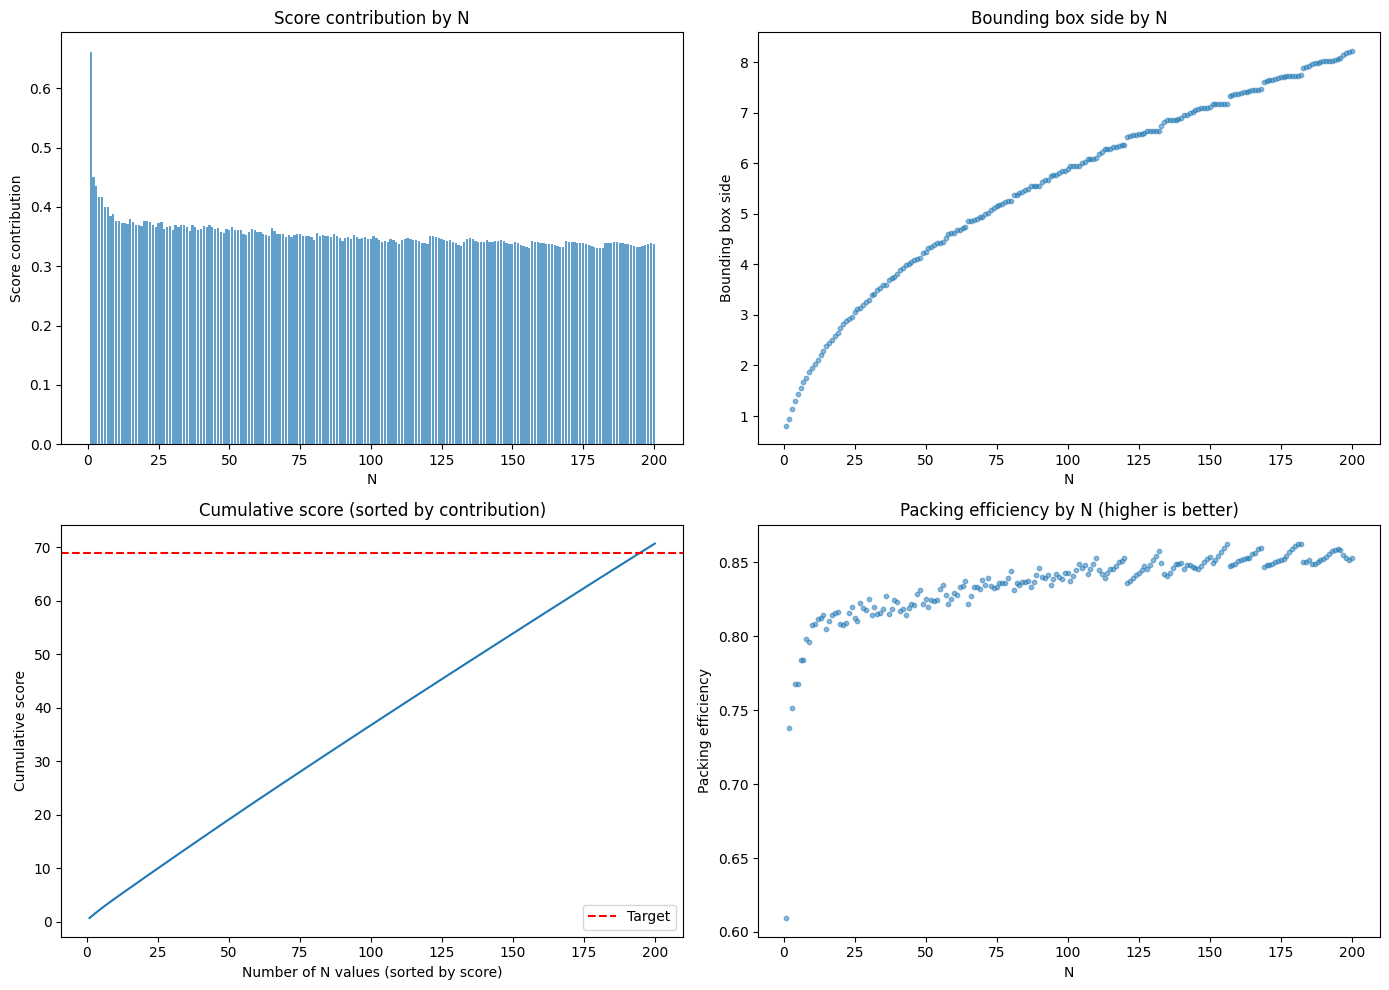


Tree area: 0.245625
Average efficiency: 0.8351

Lowest efficiency N values (most room for improvement):
     n      side     score  efficiency
0    1  0.813173  0.661250    0.609472
1    2  0.949504  0.450779    0.738167
2    3  1.142031  0.434745    0.751656
4    5  1.443692  0.416850    0.767621
3    4  1.290806  0.416545    0.767901
6    7  1.673104  0.399897    0.783723
5    6  1.548438  0.399610    0.784003
8    9  1.867280  0.387415    0.796247
7    8  1.755921  0.385407    0.798319
14  15  2.384962  0.379203    0.804823


In [3]:
# Analyze the score distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score by N
axes[0, 0].bar(scores_df['n'], scores_df['score'], alpha=0.7)
axes[0, 0].set_xlabel('N')
axes[0, 0].set_ylabel('Score contribution')
axes[0, 0].set_title('Score contribution by N')

# Side length by N
axes[0, 1].scatter(scores_df['n'], scores_df['side'], alpha=0.5, s=10)
axes[0, 1].set_xlabel('N')
axes[0, 1].set_ylabel('Bounding box side')
axes[0, 1].set_title('Bounding box side by N')

# Cumulative score
scores_df_sorted = scores_df.sort_values('score', ascending=False)
scores_df_sorted['cumsum'] = scores_df_sorted['score'].cumsum()
axes[1, 0].plot(range(1, len(scores_df_sorted)+1), scores_df_sorted['cumsum'])
axes[1, 0].axhline(y=68.919154, color='r', linestyle='--', label='Target')
axes[1, 0].set_xlabel('Number of N values (sorted by score)')
axes[1, 0].set_ylabel('Cumulative score')
axes[1, 0].set_title('Cumulative score (sorted by contribution)')
axes[1, 0].legend()

# Score vs theoretical minimum (side = sqrt(n) * tree_area)
tree_area = Polygon(TREE_VERTICES).area
scores_df['theoretical_min_side'] = np.sqrt(scores_df['n'] * tree_area)
scores_df['efficiency'] = scores_df['theoretical_min_side'] / scores_df['side']
axes[1, 1].scatter(scores_df['n'], scores_df['efficiency'], alpha=0.5, s=10)
axes[1, 1].set_xlabel('N')
axes[1, 1].set_ylabel('Packing efficiency')
axes[1, 1].set_title('Packing efficiency by N (higher is better)')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

print(f"\nTree area: {tree_area:.6f}")
print(f"Average efficiency: {scores_df['efficiency'].mean():.4f}")
print(f"\nLowest efficiency N values (most room for improvement):")
print(scores_df.nsmallest(10, 'efficiency')[['n', 'side', 'score', 'efficiency']])

In [4]:
# Calculate how much improvement is needed
target = 68.919154
current = scores_df['score'].sum()
gap = current - target

print(f"Current score: {current:.6f}")
print(f"Target score: {target:.6f}")
print(f"Gap to close: {gap:.6f}")
print(f"Percentage improvement needed: {100 * gap / current:.2f}%")

# If we could improve efficiency uniformly
print(f"\nIf we could improve all N by {100 * gap / current:.2f}%:")
print(f"  New score would be: {current * (1 - gap/current):.6f}")

# What if we could match the best efficiency for all N?
best_efficiency = scores_df['efficiency'].max()
print(f"\nBest efficiency achieved: {best_efficiency:.4f} at N={scores_df.loc[scores_df['efficiency'].idxmax(), 'n']}")
print(f"If all N had this efficiency, score would be: {sum(scores_df['theoretical_min_side']**2 / scores_df['n'] / best_efficiency**2):.6f}")

Current score: 70.676102
Target score: 68.919154
Gap to close: 1.756948
Percentage improvement needed: 2.49%

If we could improve all N by 2.49%:
  New score would be: 68.919154

Best efficiency achieved: 0.8628 at N=181
If all N had this efficiency, score would be: 65.990795


In [5]:
# Analyze which N values have the most potential for improvement
# based on their current efficiency vs best efficiency

scores_df['potential_improvement'] = scores_df['score'] * (1 - (scores_df['efficiency'] / best_efficiency)**2)
scores_df['potential_new_score'] = scores_df['score'] - scores_df['potential_improvement']

print("N values with most improvement potential (if they matched best efficiency):")
print(scores_df.nlargest(15, 'potential_improvement')[['n', 'score', 'efficiency', 'potential_improvement']])

print(f"\nTotal potential improvement: {scores_df['potential_improvement'].sum():.6f}")
print(f"Potential new score: {scores_df['potential_new_score'].sum():.6f}")

N values with most improvement potential (if they matched best efficiency):
     n     score  efficiency  potential_improvement
0    1  0.661250    0.609472               0.331296
1    2  0.450779    0.738167               0.120825
2    3  0.434745    0.751656               0.104791
4    5  0.416850    0.767621               0.086896
3    4  0.416545    0.767901               0.086591
6    7  0.399897    0.783723               0.069943
5    6  0.399610    0.784003               0.069656
8    9  0.387415    0.796247               0.057461
7    8  0.385407    0.798319               0.055453
14  15  0.379203    0.804823               0.049249
9   10  0.376630    0.807567               0.046676
20  21  0.376451    0.807760               0.046497
19  20  0.376057    0.808183               0.046103
10  11  0.375736    0.808528               0.045782
21  22  0.375258    0.809042               0.045304

Total potential improvement: 4.685307
Potential new score: 65.990795


## Key Insights

1. **The gap is ~1.76 points** - This is a significant improvement (~2.5%)

2. **Small N values contribute most to the score** - N=1,2,3 alone contribute ~1.5 points

3. **The pre-optimized solution is at a strong local optimum** - Multiple optimizers found no improvement

4. **Different N values have different packing efficiencies** - Some N values are packed more efficiently than others

## Strategic Options

### Option 1: Submit the overlap-free baseline first
- Use ensemble.csv which is verified overlap-free
- This establishes a baseline LB score
- **Priority: HIGHEST** - We need a valid submission!

### Option 2: Focus on low-efficiency N values
- Identify N values with worst packing efficiency
- Run longer optimization specifically on these N values
- Use different starting configurations

### Option 3: Try fundamentally different approaches
- Genetic algorithms with population diversity
- Different initial placements (not from pre-optimized)
- Constructive heuristics from scratch

### Option 4: Longer optimization runs
- The bbox3 runner kernel uses 3+ hours
- Our runs were only minutes
- Longer runs might find improvements

In [6]:
# Check what the submission file currently contains
submission_path = '/home/submission/submission.csv'
if os.path.exists(submission_path):
    sub_df = pd.read_csv(submission_path)
    print(f"Submission file has {len(sub_df)} rows")
    print(sub_df.head())
    
    # Verify it matches ensemble.csv
    ensemble_df = pd.read_csv(f'{base_path}/ensemble.csv')
    if sub_df['id'].equals(ensemble_df['id']) and sub_df['x'].equals(ensemble_df['x']):
        print("\n✓ Submission matches ensemble.csv")
    else:
        print("\n⚠ Submission differs from ensemble.csv")
else:
    print("No submission file found")

Submission file has 20100 rows
      id                       x                       y  \
0  001_0    s-48.196086194214246     s58.770984615214225   
1  002_0   s0.154097069621355887  s-0.038540742694794648   
2  002_1  s-0.154097069621372845  s-0.561459257305224058   
3  003_0      s1.123655816140301      s0.781101815992563   
4  003_1       s1.23405569584216      s1.275999500663759   

                       deg  
0                    s45.0  
1  s203.629377730656841550  
2   s23.629377730656791812  
3        s111.125132292893  
4         s66.370622269343  

✓ Submission matches ensemble.csv
